# Influence functions wiht EK-FAC

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from support.common import plot_losses
from support.torch import fit_torch_model
from pydvl.influence import compute_influence_factors, compute_influences_up
from pydvl.influence.torch import TorchTwiceDifferentiable
from support.shapley import load_wine_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr, spearmanr

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def print_error_stats(arr1, arr2, tag):
    print(
        f"Percentage error {tag}:{np.nanmean((np.abs(arr1 - arr2)/np.abs(arr2)))*100} %"
    )
    print(f"Pearson Correlation {tag}", pearsonr(arr1, arr2))
    print(f"Spearman Correlation {tag}", spearmanr(arr1, arr2))

In [18]:
from numpy import require


input_size = 13
middle_layers = []
output_size = 3
classification = True

train_dataset = th.utils.data.TensorDataset(
    th.randn(100, input_size), th.randint(0, output_size, (100,))
)
val_dataset = th.utils.data.TensorDataset(
    th.randn(100, input_size), th.randint(0, output_size, (100,))
)
# loss = lambda x, y: F.cross_entropy(x, y, reduction="sum")
loss = F.cross_entropy

loader = th.utils.data.DataLoader(train_dataset, batch_size=10)

layers = []
layers_size = [input_size] + middle_layers + [output_size]
new_layer = nn.Linear(input_size, input_size)
for param in new_layer.parameters():
    param.requires_grad = False
layers.append(new_layer)

for frm, to in zip(layers_size[:-1], layers_size[1:]):
    layers.append(nn.Linear(frm, to))
    layers.append(nn.Tanh())
layers.append(nn.Softmax(dim=-1))
model = nn.Sequential(*layers)

In [19]:
optimizer = Adam(model.parameters(), lr=0.01)
losses = fit_torch_model(
    model,
    training_data=train_dataset,
    val_data=val_dataset,
    loss=loss,
    optimizer=optimizer,
    num_epochs=100,
)

Model fitting: 100%|██████████| 100/100 [00:04<00:00, 21.75it/s]


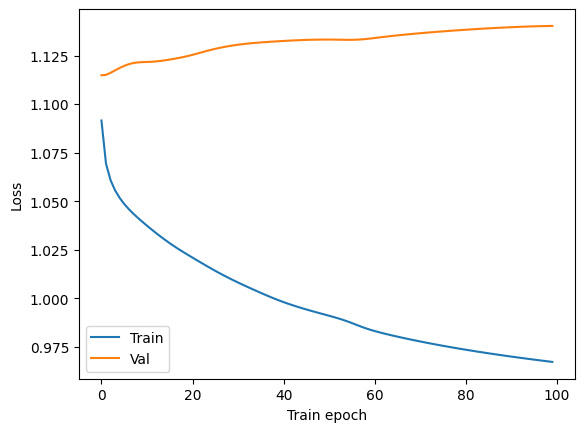

In [20]:
plot_losses(losses)

In [21]:
model.eval()
wrapped_model = TorchTwiceDifferentiable(model, loss)

In [22]:
direct_if_factors, direct_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="direct",
    hessian_perturbation=0.1,
    progress=False,
)
direct_influences = compute_influences_up(
    wrapped_model, loader, direct_if_factors, progress=True
)
mean_direct_influences = np.mean(direct_influences.numpy(), axis=0)
direct_hessian = direct_info["hessian"]

Batch Split Input Gradients:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 282.77it/s]


In [23]:
np.any(np.isnan(direct_influences.numpy()))

False

In [29]:
ekfac_if_factors, ekfac_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="ekfac",
    hessian_perturbation=0.1,
    update_diag=True,
    progress=True,
)
ekfac_influences = compute_influences_up(
    wrapped_model, loader, ekfac_if_factors, progress=True
)
mean_ekfac_influences = np.mean(ekfac_influences.numpy(), axis=0)
ekfac_hessian = ekfac_info["hessian"]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 154.15it/s]


In [30]:
np.any(np.isnan(ekfac_influences.numpy()))

False

In [31]:
print_error_stats(mean_ekfac_influences, mean_direct_influences, tag="influence values")

Percentage error influence values:34.00816321372986 %
Pearson Correlation influence values PearsonRResult(statistic=0.996555122587826, pvalue=8.74956622972315e-108)
Spearman Correlation influence values SignificanceResult(statistic=0.9864986498649864, pvalue=8.050285574439215e-79)


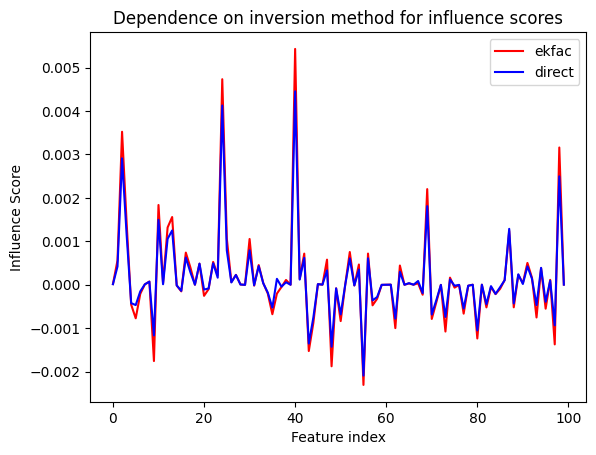

In [27]:
plt.plot(mean_ekfac_influences, color="red")
plt.plot(mean_direct_influences, color="blue")
plt.legend(["ekfac", "direct"])
plt.xlabel("Feature index")
plt.ylabel("Influence Score")
plt.title("Dependence on inversion method for influence scores")
plt.show()

In [14]:
direct_eig = np.linalg.eig(direct_hessian)[0]
ekfac_eig = np.linalg.eig(ekfac_hessian)[0]

In [15]:
print_error_stats(direct_eig.real, ekfac_eig.real, tag="eigen values")

Percentage error eigen values:58776.336669921875 %
Pearson Correlation eigen values PearsonRResult(statistic=0.9324969122892823, pvalue=2.728093131574819e-19)
Spearman Correlation eigen values SignificanceResult(statistic=0.9577019690462685, pvalue=3.0017279912847474e-23)


In [16]:
np.sum(direct_hessian.numpy() == 0)

0

In [17]:
ekfac_hessian - direct_hessian

tensor([[-3.9258e-03,  6.6164e-04,  1.6425e-03,  ...,  1.3624e-03,
          1.8512e-05,  1.5725e-05],
        [ 6.6164e-04, -1.1867e-02, -2.4622e-03,  ...,  5.2236e-03,
          2.1212e-05,  7.8337e-05],
        [ 1.6425e-03, -2.4622e-03, -1.8050e-02,  ...,  1.4578e-03,
         -6.4030e-06,  5.3265e-06],
        ...,
        [ 1.3624e-03,  5.2236e-03,  1.4578e-03,  ..., -1.0591e-02,
          1.1850e-04, -6.7288e-05],
        [ 1.8512e-05,  2.1212e-05, -6.4030e-06,  ...,  1.1850e-04,
         -6.4374e-03,  9.8718e-06],
        [ 1.5725e-05,  7.8337e-05,  5.3265e-06,  ..., -6.7288e-05,
          9.8718e-06, -2.9394e-03]])